In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/Users/kmarvel/Google Drive/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

computer="laptop"
if computer is "laptop":
    rootdirec="/Volumes/MarvelCMIP6/DROUGHT/"
else:
    rootdirec="/Users/kmarvel/Documents/DATA/"
    
vcert=stats.norm.interval(.99)[1]

#Region locations
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]=cdutil.region.domain(longitude=(-125,-111),latitude=(42,49))
#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]=cdutil.region.domain(longitude=(-124,-102),latitude=(31,42))
#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]=cdutil.region.domain(longitude=(-116,-95),latitude=(40,49))
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]=cdutil.region.domain(longitude=(-107,-93),latitude=(26,40))
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]=cdutil.region.domain(longitude=(-97,-80),latitude=(36,50))
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]=cdutil.region.domain(longitude=(-82,-67),latitude=(37,48))
#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]=cdutil.region.domain(longitude=(-95,-76),latitude=(25,39))





In [2]:
from scipy import signal

def FourierPlot(tas):
    detrend = signal.detrend(tas)
    L = len(tas)
    freqs = np.fft.fftfreq(L)
    tas_fft = np.fft.fft(detrend)
    R = tas_fft.real
    Im = tas_fft.imag
    mag = np.sqrt(R**2+Im**2)
    plt.plot(1/freqs,mag)
def annual_cycle_dominant(tas):
    """Check to see whether the annual cycle is dominant"""
    detrend = signal.detrend(tas)
    L = len(tas)
    freqs = np.fft.fftfreq(L)
    tas_fft = np.fft.fft(detrend)
    R = tas_fft.real
    Im = tas_fft.imag
    mag = np.sqrt(R**2+Im**2)
    the_period = 1./np.abs(freqs[np.argmax(mag)])
    return the_period

def get_dominant_cycle(tas):
    nt,nlat,nlon = tas.shape
    to_mask = MV.zeros((nlat,nlon))
    for i in range(nlat):
        for j in range(nlon):
            to_mask[i,j]=annual_cycle_dominant(tas[:,i,j])
    to_mask.setAxisList(tas.getAxisList()[1:])
    return to_mask
def get_cycle(tas,period=12,return_complex=False):

    L = len(tas)
    freqs = np.fft.fftfreq(L)
    closest = np.abs(freqs-1./period)
    
#    i = np.where(freqs == 1./period)[0]
    i = np.argmin(closest)
   # print(1/freqs[i])
    tas_fft = np.fft.fft(tas)/L
    R = tas_fft.real
    Im = tas_fft.imag
    if return_complex:
        return R[i],Im[i]
    else:
        mag = np.sqrt(R**2+Im**2)
        phase = np.arctan2(Im,R)
        return mag[i],phase[i]
def day_of_peak(phase):
    #make sure phase lies between [0,2pi]
    phase=stats.circmean(phase)
    days=np.arange(365)
    func=np.cos(2*np.pi/12*np.linspace(0,12,365)+phase)
    #return the day of max variable if it's between spring and fall
    #if (phase>np.pi/4) and (phase<7*np.pi/4):
    return float(days[np.argmax(func)])
   # #otherwise winter
   # else:
       # return float(days[np.argmin(func)])
vec_day_of_peak=np.vectorize(day_of_peak)

def day_of_trough(phase):
    #make sure phase lies between [0,2pi]
    phase=stats.circmean(phase)
    days=np.arange(365)
    func=np.cos(2*np.pi/12*np.linspace(0,12,365)+phase)
    #return the day of max variable if it's between spring and fall
    #if (phase>np.pi/4) and (phase<7*np.pi/4):
    return float(days[np.argmin(func)])
   # #otherwise winter
   # else:
       # return float(days[np.argmin(func)])
vec_day_of_trough=np.vectorize(day_of_trough)

In [4]:
import DroughtHelper as dh
#from importlib import reload
#reload(dh)

In [5]:
def get_amplitude_and_phase_from_file(fname):
  
    f=cdms.open(fname)
    variable=fname.split("/")[-1].split(".")[0]
    data=f(variable)
    cdutil.setTimeBoundsMonthly(data)
   
    data_year=cdutil.YEAR(data)
    nyears=int(data.shape[0]/12)
    
   

    A=MV.array([get_cycle(data[i*12:12*(i+1)])[0] for i in range(nyears)])
    P=MV.array([get_cycle(data[i*12:12*(i+1)])[1] for i in range(nyears)])
    
        
    A=MV.masked_where(data_year.mask,A)
    A.setAxisList(data_year.getAxisList())
    A.id="amp"

    P=MV.masked_where(data_year.mask,P)
    P.setAxisList(data_year.getAxisList())
    P.id="phase"
    f.close()
    return A,P

In [6]:
def calculate_anomalies():
    if anomaly:
        if scenario.find("hist")>0:
            Aclim=MV.average(A(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Aclim=MV.average(A(time=('2015-1-1','2035-12-31')),axis=1)
        Aanom=cmip5.cdms_clone(A-np.repeat(Aclim.asma()[:,np.newaxis],nyears,axis=1),A)
        Aanom.id="amp_anom"
        if scenario.find("hist")>0:
            Pclim=stats.circmean(P(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Pclim=stats.circmean(P(time=('2015-1-1','2035-12-31')),axis=1)
        
        Panom=cmip5.cdms_clone(vec_day_of_peak(P)-np.repeat(vec_day_of_peak(Pclim)[:,np.newaxis],nyears,axis=1),P)
        Panom.id="phase_anom"
        return Aanom,Panom
    else:
        return A,P

In [22]:
data=dh.TOE("tas","NW")


In [24]:
glob.glob("/Volumes/MarvelCMIP6/NCA4regions/*")

[]

In [7]:
def get_amplitude_and_phase(variable,region,scenario="hist+ssp585",anomaly=True,raw=False):
    data=dh.TOE(variable,region)

    if scenario.find("+")>0:
        ssp=scenario.split("+")[-1]
        hssp=data.splice_historical(ssp)
    else:
        hssp=data.ensemble_average(scenario)
    hssp_year=cdutil.YEAR(hssp)
    nyears=int(hssp.shape[1]/12)
    nmod=int(hssp.shape[0])
    A=MV.zeros((nmod,nyears))
    P=MV.zeros((nmod,nyears))

    for counter in range(nmod):
        x=hssp[counter]
        amps=[get_cycle(x[i*12:12*(i+1)])[0] for i in range(nyears)]
        phases=[get_cycle(x[i*12:12*(i+1)])[1] for i in range(nyears)]
        A[counter]=amps
        P[counter]=phases
    A=MV.masked_where(hssp_year.mask,A)
    A.setAxisList(hssp_year.getAxisList())
    A.id="amp"

    P=MV.masked_where(hssp_year.mask,P)
    P.setAxisList(hssp_year.getAxisList())
    P.id="phase"

    if anomaly:
        if scenario.find("hist")>0:
            Aclim=MV.average(A(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Aclim=MV.average(A(time=('2015-1-1','2035-12-31')),axis=1)
        Aanom=cmip5.cdms_clone(A-np.repeat(Aclim.asma()[:,np.newaxis],nyears,axis=1),A)
        Aanom.id="amp_anom"
        if scenario.find("hist")>0:
            Pclim=stats.circmean(P(time=('1980-1-1','2014-12-31')),axis=1)
        else:
            Pclim=stats.circmean(P(time=('2015-1-1','2035-12-31')),axis=1)
        
        Panom=cmip5.cdms_clone(vec_day_of_peak(P)-np.repeat(vec_day_of_peak(Pclim)[:,np.newaxis],nyears,axis=1),P)
        Panom.id="phase_anom"
        if raw:
            return A,Aanom,P,Panom
        else:
            return Aanom,Panom
    else:
        return A,P





In [8]:
def generate_all_amplitudes_phases():
    base_read_dir="/Volumes/MarvelCMIP6/DROUGHT/NCA4/"
    base_write_dir="/Volumes/MarvelCMIP6/DROUGHT/AmplitudePhase/"

    regions=NCA4regions.keys()
   
    allvariables=['tas', 'mrro', 'mrros', 'mrso',"mrsos", 'pr', 'evspsbl', 'prsn']
    
    experiments=["piControl","historical","ssp126","ssp585","ssp370","ssp245"]
    
    for region in regions:
        for variable in allvariables:
            for experiment in experiments:
                os.makedirs(os.path.join(base_write_dir, region,variable,experiment),exist_ok=True)
                readdirec=os.path.join(base_read_dir, region,variable,experiment)+"/"
                fnames=glob.glob(readdirec+"*")
                
                for fname in fnames:
                    fwritename=fname.replace("NCA4","AmplitudePhase")
                    if fwritename not in glob.glob(os.path.join(base_write_dir, region,variable,experiment)+"/*"):
                        
                        A,P=get_amplitude_and_phase_from_file(fname)
                        fwrite=cdms.open(fwritename,"w")
                        fwrite.write(A)
                        fwrite.write(P)
                        fwrite.close()
                    


In [72]:
#generate_all_amplitudes_phases()

In [9]:
def ensemble_average_data(data,models=None):

    nens,ntime=data.shape

    if models is None:
        models=np.unique([fname.split(".")[2] for fname in cmip5.models(data)])
        #models=get_ok_models("NW")

    nmod=len(models)

    EnsembleAverage=np.ma.zeros((nmod,ntime))+1.e20

    #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem))
    fnames=cmip5.models(data)
    
    counter=0
    for model in models:
        #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
        I=np.where([x.split(".")[2]==model for x in fnames])[0]
        if len(I)>0:
            EnsembleAverage[counter]=np.ma.average(data.asma()[I],axis=0)

        else:
            
            print("missing data for "+model)
        counter+=1

    EnsembleAverage=MV.masked_where(np.abs(EnsembleAverage)>1.e10,EnsembleAverage)
    EnsembleAverage=MV.masked_where(np.isnan(EnsembleAverage),EnsembleAverage)
    EnsembleAverage=MV.array(EnsembleAverage)
    EnsembleAverage.setAxis(1,data.getTime())
    modax=cmip5.make_model_axis(models)
    EnsembleAverage.setAxis(0,modax)
    cdutil.setTimeBoundsMonthly(EnsembleAverage)    

    return EnsembleAverage

In [523]:
def splice_data(hdata,sspdata):
    scenario=cmip5.models(sspdata)[0].split("/")[-2]
    sspmodels=[fname.split(".")[2] for fname in cmip5.models(sspdata)]
    ssprips=[fname.split(".")[3] for fname in cmip5.models(sspdata)]
    sspids=[]
    for mod,rip in zip(sspmodels,ssprips):
        sspids+=[mod+"."+rip]


    hmodels=[fname.split(".")[2] for fname in cmip5.models(hdata)]
    hrips=[fname.split(".")[3] for fname in cmip5.models(hdata)]
    hids=[mod+"."+rip for mod,rip in zip(hmodels,hrips)]


    lenhist=hdata.shape[1]
    lenssp=sspdata.shape[1]
    intersect=np.intersect1d(np.array(hids),np.array(sspids))
    nmod=len(intersect)
    spliced=MV.zeros((nmod,lenhist+lenssp))
    counter=0
    splicedmods=[]
    for pr in intersect:
        i=hids.index(pr)

        j=sspids.index(pr)
        dat=MV.concatenate((hdata[i],sspdata[j]))
        spliced[counter]=dat
        splicedmods+=[cmip5.models(hdata)[i].replace("historical","historical_"+scenario)]
        #print(cmip5.models(hdata)[i])
        counter+=1
    modax=cmip5.make_model_axis(splicedmods)
    nyears=lenhist+lenssp
    tax=cdms.createAxis(np.arange(6,nyears*12,12))
    tax.designateTime()
    tax.id="time"
    htax=hdata.getTime()
    for att in htax.attributes.keys():
        setattr(tax,att,htax.attributes[att])
    spliced.setAxisList([modax,tax])
    spliced.id=hdata.id
    return spliced

In [10]:
def get_ensemble_filenames(variable,region,experiment,readstem="/Volumes/MarvelCMIP6/DROUGHT/NCA4/"):
    fnames=[]
    for model in get_ok_models(region,variables=[variable]):
        fnames+=glob.glob(readstem+region+"/"+variable+"/"+experiment+"/"+variable+"."+experiment+"."+model+".*")
    return fnames
def get_available_models(variable,experiment,region):
    return np.unique([x.split(".")[-3] for x in glob.glob("/Volumes/MarvelCMIP6/DROUGHT/NCA4/"+region+"/"+variable+"/"+experiment+"/*")])
def get_ok_models(region,variables=None):
    models=[x.split("_fx_")[-1].split(".")[0] for x in glob.glob("/Volumes/MarvelCMIP6/DROUGHT/fixedvar/sftlf*")]
    if variables is None:
        variables=['tas', 'mrro', 'mrros', 'mrso', 'pr',"evspsbl","mrsos","prsn"] #add mrsos, evspsbl and prsn when they download
    experiments=["piControl","historical","ssp585"] #require at least 1 ens member in each of these experiments
    for variable in variables:
        for experiment in experiments:
            models=np.intersect1d(models,get_available_models(variable,experiment,region))
    return models
class AmpPhase():
    def __init__(self,variable,region,verbose=False):
        self.variable=variable
        self.region=region
        self.verbose=verbose
        self.readstem = "/Volumes/MarvelCMIP6/DROUGHT/AmplitudePhase/"
    def get_ensemble(self,experiment):
        if not hasattr(self,experiment):
            if experiment != "piControl":
                fnames=get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem)
                nfiles=len(fnames)
                i=0
                fil=fnames[i]
                f=cdms.open(fil)
                ampdata=f("amp")
                phasedata=f("phase")
                tax=ampdata.getTime()
                #if experiment != "piControl":
                ntime=len(tax)

                all_ampdata=MV.zeros((nfiles,ntime))+1.e20
                all_phasedata=MV.zeros((nfiles,ntime))+1.e20
                all_ampdata[i]=ampdata[:ntime]
                all_phasedata[i]=phasedata[:ntime]
                f.close()
                for i in range(nfiles)[1:]:
                    fil=fnames[i]
                    f=cdms.open(fil)
                    ampdata=f("amp")
                    phasedata = f("phase")
                    if len(ampdata.getTime())==ntime:
                        all_ampdata[i]=ampdata
                        all_phasedata[i]=phasedata
                    elif len(ampdata.getTime())>ntime:
                        all_ampdata[i]=ampdata[:ntime]
                        all_phasedata[i]=phasedata[:ntime]
                    else:
                        badlength=len(ampdata.getTime())
                        all_ampdata[i,:badlength]=ampdata
                        all_phasedata[i,:badlength]=phasedata
                    f.close()
                all_ampdata=MV.masked_where(np.abs(all_ampdata)>1.e10,all_ampdata)
                all_ampdata.setAxis(1,tax)    
                modax=cmip5.make_model_axis(fnames)
                all_ampdata.setAxis(0,modax)
                
                all_phasedata=MV.masked_where(np.abs(all_phasedata)>1.e10,all_phasedata)
                all_phasedata.setAxis(1,tax)    
                modax=cmip5.make_model_axis(fnames)
                all_phasedata.setAxis(0,modax)
                #convert soil moisture to z scores
                # if self.variable in ["mrso","mrsos"]:
                #     alldata=self.standardize_zcore(alldata)
                # else:
                #     alldata=self.convert_to_percentage(alldata)
                setattr(self,experiment,{})
                getattr(self,experiment)["amp"]=MV.masked_where(np.abs(all_ampdata)>1.e10,all_ampdata)
                getattr(self,experiment)["phase"]=MV.masked_where(np.abs(all_phasedata)>1.e10,all_phasedata)
            else:
                all_ampdata,all_phasedata=self.concatenate_piControl()
                setattr(self,experiment,{})
                getattr(self,experiment)["amp"]=MV.masked_where(np.abs(all_ampdata)>1.e10,all_ampdata)
                getattr(self,experiment)["phase"]=MV.masked_where(np.abs(all_phasedata)>1.e10,all_phasedata)
                
    def concatenate_piControl(self,season=None,compressed=False):
        experiment="piControl"
        fnames=sorted(get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem))
        #models=sorted(self.ensemble_dict.keys())
        models=get_ok_models(self.region,variables=[self.variable])
        
        nmod=len(models)
        ntimes=[]
        model_names=[]
        #Loop over without loading data to figure out the shortest length control run
        for model in models:
           # print(model)
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                first_member=int(I[0])
       
                fname=fnames[first_member]
          
                model_names+=[fname]
                f=cdms.open(fname)
                ntimes+=[int(f["amp"].shape[0])]
                f.close()
        L=np.min(ntimes)
        #Set the time axis to be the time axis of the shortest control rin
        imin=np.argmin(ntimes)

        fshortest=model_names[imin]
        f=cdms.open(fshortest)
        tax=f("amp").getTime()
        tax.id='time'
        tax.designateTime()
        f.close()
        #Load data
        #SingleMember=np.ma.zeros((len(model_names),L))+1.e20
        SingleMember_amp=np.ma.zeros((nmod,L))+1.e20
        SingleMember_phase=np.ma.zeros((nmod,L))+1.e20
        i=0
        make_modax=[]
        for model in models:
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                first_member=I[0]
                fname=fnames[first_member]
                f=cdms.open(fname)
                ampdata=f("amp")
                SingleMember_amp[i]=ampdata[:L]
                make_modax+=[fname]
                phasedata=f("phase")
                SingleMember_phase[i]=phasedata[:L]
                i+=1
            else:
                if self.verbose:
                    print("No piControl data for "+model+" "+self.variable)
            
            f.close()
        
        
        SingleMember_amp=MV.masked_where(np.abs(SingleMember_amp)>1.e10,SingleMember_amp)
        SingleMember_amp=MV.array(SingleMember_amp)
        SingleMember_amp.setAxis(1,tax)
        SingleMember_amp.setAxis(0,cmip5.make_model_axis(make_modax))
        ###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
        SingleMember_amp=MV.masked_where(SingleMember_amp==0,SingleMember_amp)
        
        SingleMember_phase=MV.masked_where(np.abs(SingleMember_phase)>1.e10,SingleMember_phase)
        SingleMember_phase=MV.array(SingleMember_phase)
        SingleMember_phase.setAxis(1,tax)
        SingleMember_phase.setAxis(0,cmip5.make_model_axis(models))
        ###KLUDGE: FIRST YEAR IS ZERO- FIX THIS IN DOWNLOADER
        SingleMember_phase=MV.masked_where(SingleMember_phase==0,SingleMember_phase)
        cdutil.setTimeBoundsMonthly(SingleMember_amp)
        cdutil.setTimeBoundsMonthly(SingleMember_phase)
        
        return SingleMember_amp,SingleMember_phase
    def ensemble_average(self,experiment):
        self.get_ensemble(experiment)
        amp_data=getattr(self,experiment)["amp"]
        phase_data=getattr(self,experiment)["phase"]
        nens,ntime=amp_data.shape
        #models=sorted(self.ensemble_dict.keys())
        models=get_ok_models(self.region,variables=[self.variable])
        
        nmod=len(models)
       # print("Number of models is", nmod)
        EnsembleAverage_amp=np.ma.zeros((nmod,ntime))+1.e20
        EnsembleAverage_phase=np.ma.zeros((nmod,ntime))+1.e20
        fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment,readstem=self.readstem))
        counter=0
        for model in models:
            #fnames=np.array(get_ensemble_filenames(self.variable,self.region,experiment))
            I=np.where([x.split(".")[2]==model for x in fnames])[0]
            if len(I)>0:
                EnsembleAverage_amp[counter]=np.ma.average(amp_data.asma()[I],axis=0)
                EnsembleAverage_phase[counter]=stats.circmean(phase_data.asma()[I],axis=0)
            else:
                if self.verbose:
                    print("missing data for "+model+" "+self.variable+" "+experiment)
            counter+=1
            
        EnsembleAverage_amp=MV.masked_where(np.abs(EnsembleAverage_amp)>1.e10,EnsembleAverage_amp)
        EnsembleAverage_amp=MV.masked_where(np.isnan(EnsembleAverage_amp),EnsembleAverage_amp)
        EnsembleAverage_amp=MV.array(EnsembleAverage_amp)
        EnsembleAverage_amp.setAxis(1,amp_data.getTime())
        modax=cmip5.make_model_axis(models)
        EnsembleAverage_amp.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(EnsembleAverage_amp)    
        
        EnsembleAverage_phase=MV.masked_where(np.abs(EnsembleAverage_phase)>1.e10,EnsembleAverage_phase)
        EnsembleAverage_phase=MV.masked_where(np.isnan(EnsembleAverage_phase),EnsembleAverage_phase)
        EnsembleAverage_phase=MV.array(EnsembleAverage_phase)
        EnsembleAverage_phase.setAxis(1,phase_data.getTime())
    
        EnsembleAverage_phase.setAxis(0,modax)
        cdutil.setTimeBoundsMonthly(EnsembleAverage_phase)    
        
        setattr(self,experiment+"_average",{})
        getattr(self,experiment+"_average")["amp"]=EnsembleAverage_amp
        getattr(self,experiment+"_average")["phase"] = EnsembleAverage_phase
        
    
       
    def anomalize(self,experiment):
        if not hasattr(self,experiment):
            
            self.get_ensemble(experiment)
          
                
        data=getattr(self,experiment)
        if not hasattr(self,"historical_average"):
            self.ensemble_average("historical")
        hist=getattr(self,"historical_average")
        
        Ahist=hist["amp"]
        Aclim=MV.average(Ahist(time=('1980-1-1','2014-12-31')),axis=1)
        A=data["amp"]
        Aanom=np.ma.zeros(A.shape)+1.e20
        
        Phist=hist["phase"]
        Pclim=stats.circmean(Phist(time=('1980-1-1','2014-12-31')),axis=1)
        P=data["phase"]
        Panom=np.ma.zeros(P.shape)+1.e20
        
        datamodels=cmip5.models(A)
        histmodels=cmip5.models(Ahist)
        nmod,nyears=A.shape
        for i in range(nmod):
            j=histmodels.index(datamodels[i].split(".")[2])
            Aanom[i]=A[i]-Aclim[j]
            
            climpeak=day_of_peak(Pclim[j])
            

            thisyear_peak=vec_day_of_peak(P[i])
            
            climtrough=day_of_trough(Pclim[j])
            

            thisyear_trough=vec_day_of_trough(P[i])
            pk=thisyear_peak-climpeak
            trh=thisyear_trough-climtrough
            anom=np.where(np.abs(pk) > np.abs(trh), trh, pk)
            
            Panom[i]=anom
            
        Aanom=MV.masked_where(A.mask,Aanom)
        Aanom=cmip5.cdms_clone(Aanom,A)
        Aanom.id="amp_anom"
        
        
        Panom=MV.masked_where(P.mask,Panom)
        Panom=cmip5.cdms_clone(Panom,P)
        Panom.id="phase_anom"
        
        getattr(self,experiment)["amp_anom"]=Aanom
        getattr(self,experiment)["phase_anom"]=Panom
        
    def end_of_century(self):
        P={}
        A={}
        self.anomalize("historical")
        self.anomalize("ssp585")
        self.anomalize("ssp370")
        self.anomalize("ssp245")
        self.anomalize("ssp126")
        self.anomalize("piControl")
        
        piC=self.piControl["amp_anom"]
        noise=DA_tools.concatenate_this(piC)
        slopes=dh.bootstrap_slopes(noise,86)



        ssp1data=MV.average(ensemble_average_data(self.ssp126["amp_anom"]),axis=0)
        ssp3data=MV.avdata=MV.average(ensemble_average_data(self.ssp370["amp_anom"]),axis=0)

        ssp2data=MV.average(ensemble_average_data(self.ssp245["amp_anom"]),axis=0)
        ssp5data=MV.average(ensemble_average_data(self.ssp585["amp_anom"]),axis=0)

        #A["noise"]=slopes
        A["noise"]=np.ma.std(slopes)
        for scenario in ["ssp126","ssp245","ssp370","ssp585"]:
            data=MV.average(ensemble_average_data(getattr(self,scenario)["amp_anom"]),axis=0)
            A[scenario]=float(cmip5.get_linear_trends(data))

        piC=self.piControl["phase_anom"]
        noise=DA_tools.concatenate_this(piC)
        slopes=dh.bootstrap_slopes(noise,86)



        ssp1data=MV.average(ensemble_average_data(self.ssp126["phase_anom"]),axis=0)
        ssp3data=MV.avdata=MV.average(ensemble_average_data(self.ssp370["phase_anom"]),axis=0)

        ssp2data=MV.average(ensemble_average_data(self.ssp245["phase_anom"]),axis=0)
        ssp5data=MV.average(ensemble_average_data(self.ssp585["phase_anom"]),axis=0)

        #P["noise"]=slopes
        P["noise"]=np.ma.std(slopes)
        for scenario in ["ssp126","ssp245","ssp370","ssp585"]:
            data=MV.average(ensemble_average_data(getattr(self,scenario)["phase_anom"]),axis=0)
            P[scenario]=float(cmip5.get_linear_trends(data))
        return A,P



In [569]:
SN={}
for region in NCA4regions.keys():
    SN[region]={}
    for variable in ["tas","mrro","mrros","mrso","mrsos","pr","evspsbl","prsn"]:
        SN[region][variable]={}
        X=AmpPhase(variable,region)
        A,P=X.end_of_century()
        SN[region][variable]["amp"]=A
        SN[region][variable]["phase"]=P
import pickle
with open("SNamp_phase.pickle","wb") as handle:
    pickle.dump(d,handle,protocol=pickle.HIGHEST_PROTOCOL)        

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


In [565]:
import pickle
with open("SNamp_phase.pickle","wb") as handle:
    pickle.dump(d,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
import pickle
with open("SNamp_phase.pickle", 'rb') as handle:
    unserialized_data = pickle.load(handle)


In [19]:
unserialized_data

{'sigma': 0.43451805341425015,
 'ssp126': -0.010943523092209364,
 'ssp245': -0.05973334836474018,
 'ssp370': -0.526421662052588,
 'ssp585': -0.5667505935814582}

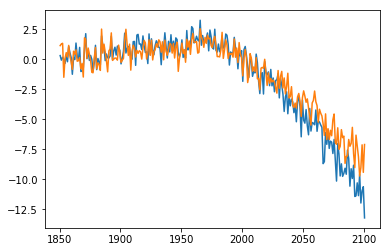

In [519]:
#print(AP.historical["phase_anom"].shape)
#[Plotting.time_plot(AP.ssp585["phase_anom"][i]) for i in range(72)]
#bad=np.where(np.abs(AP.ssp585["phase_anom"])>100)
#Plotting.time_plot(MV.average(ensemble_average_data(AP.ssp585["phase_anom"]),axis=0),c="k")
#Plotting.time_plot(MV.average(ensemble_average_data(AP.historical["phase_anom"]),axis=0),c="r")
#Plotting.time_plot(MV.average(test.mrros["phase_anomaly"],axis=0))
Plotting.time_plot(MV.average(ensemble_average_data(spliced585),axis=0))
Plotting.time_plot(MV.average(ensemble_average_data(spliced370),axis=0))

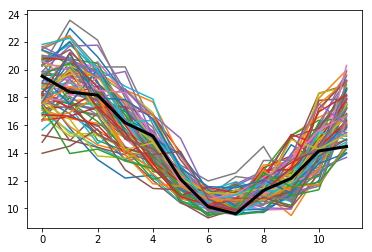

In [246]:
RAW=dh.TOE("mrsos","SW")
RAW.get_ensemble("ssp585")
tmp=[plt.plot(RAW.ssp585[55,12*j:12*(j+1)].asma()) for j in range(86)]
plt.plot(RAW.ssp585[55,12*23:12*(23+1)].asma(),c="k",lw=3)

In [256]:
data=AP.ssp585
AP.ensemble_average("historical")
hist=AP.historical_average     
Ahist=hist["phase"]
Aclim=MV.average(Ahist(time=('1980-1-1','2014-12-31')),axis=1)
A=data["amp"]
Aanom=np.ma.zeros(A.shape)+1.e20

Phist=hist["phase"]
Pclim=stats.circmean(Phist(time=('1980-1-1','2014-12-31')),axis=1)
P=data["phase"]
Panom=np.ma.zeros(P.shape)+1.e20

datamodels=cmip5.models(A)
histmodels=cmip5.models(Ahist)

In [20]:
class regional_shifts():
    def __init__(self,region):
        self.region=region
        variables=['tas', 'mrro', 'mrros', 'mrso',"mrsos", 'pr', 'evspsbl', 'prsn']
        for variable in variables:
            A,Aanom,P,Panom=get_amplitude_and_phase(variable,self.region,scenario="historical+ssp585",anomaly=True,raw=True)
            setattr(self,variable,{})
            getattr(self,variable)["amplitude"]=A
            getattr(self,variable)["amplitude_anomaly"]=Aanom
            getattr(self,variable)["phase"]=P
            getattr(self,variable)["phase_anomaly"]=Panom
            
            
            #getattr(self,variable)
test=regional_shifts("SW")


/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


OSError: NetCDF: HDF error

In [21]:
A,Aanom,P,Panom=get_amplitude_and_phase("tas","NW",scenario="historical+ssp585",anomaly=True,raw=True)

IndexError: list index out of range

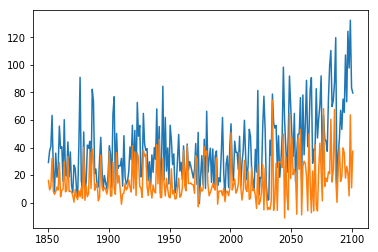

In [315]:
#Plotting.time_plot(MV.average(test.evspsbl["phase"],axis=0))
#Plotting.time_plot(MV.average(test.tas["phase"],axis=0))
Plotting.time_plot(MV.average(test.mrros["phase_anomaly"],axis=0))
Plotting.time_plot(MV.average(test.mrro["phase_anomaly"],axis=0))

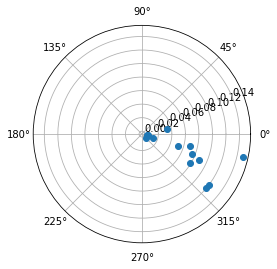

In [68]:
variable="mrros"
Aclim=MV.average(getattr(test,variable)["amplitude"],axis=1)
Pclim=stats.circmean(getattr(test,variable)["phase"],axis=1)
plt.polar(Pclim,Aclim.asma(),"o")

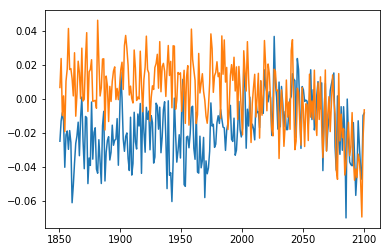

In [488]:
Plotting.time_plot(MV.average(AGPU,axis=0))
Plotting.time_plot(MV.average(ASW,axis=0))

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


missing data for EC-Earth3-Veg evspsbl ssp585


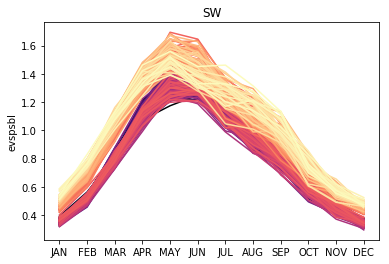

In [511]:
X=dh.TOE("evspsbl","SW",verbose=True)
X.plot_seasonal_trends(scenario="historical+ssp585")

In [509]:
test=X.splice_historical("ssp585",single_member=True)
cdutil.setTimeBoundsMonthly(test)
mma=MV.average(test[:6],axis=0)
nyears=int(len(mma)/12)
tst=mma.reshape((nyears,12)).asma()

#jja=cdutil.JJA(tst)
#ac=cdutil.ANNUALCYCLE.departures(tst)

In [530]:
def get_available_models(variable,experiment,region):
    return np.unique([x.split(".")[-3] for x in glob.glob("/Volumes/MarvelCMIP6/DROUGHT/NCA4/"+region+"/"+variable+"/"+experiment+"/*")])
def get_ok_models(region,variables=None):
    models=[x.split("_fx_")[-1].split(".")[0] for x in glob.glob("/Volumes/MarvelCMIP6/DROUGHT/fixedvar/sftlf*")]
    if variables is None:
        variables=['tas', 'mrro', 'mrros', 'mrso', 'pr',"evspsbl","mrsos","prsn"] #add mrsos, evspsbl and prsn when they download
    experiments=["piControl","historical","ssp585"] #require at least 1 ens member in each of these experiments
    for variable in variables:
        for experiment in experiments:
            models=np.intersect1d(models,get_available_models(variable,experiment,region))
    return models
newvs=get_ok_models("SW")
oldvs=get_ok_models("SW",variables=['tas', 'mrro', 'mrros', 'mrso', 'pr'])
testvs=get_ok_models("SW",variables=['tas', 'mrro', 'mrros', 'mrso', 'pr',"mrsos"])
np.setdiff1d(oldvs,newvs)


array(['CESM2', 'CESM2-WACCM', 'EC-Earth3-Veg'], dtype='<U15')

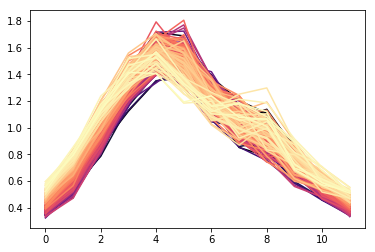

In [510]:
tmp=[plt.plot(tst[i],c=cm.magma(i/float(nyears))) for i in range(nyears)]
#plt.plot(tst[165])
#plt.plot(tst[164],c="b")

In [415]:
nyears=int(h85.shape[1]/12)
nmod=int(h85.shape[0])
A=MV.zeros((nmod,nyears))
P=MV.zeros((nmod,nyears))
#ssp=EV.ensemble_average("ssp585")
for counter in range(nmod):
    x=h85[counter]
    amps=[get_cycle(x[i*12:12*(i+1)])[0] for i in range(nyears)]
    phases=[get_cycle(x[i*12:12*(i+1)])[1] for i in range(nyears)]
    A[counter]=amps
    P[counter]=phases

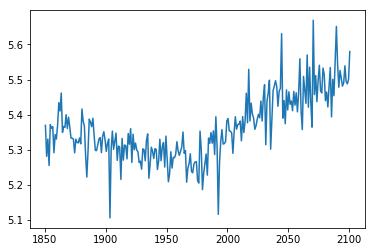

In [416]:
A=MV.masked_where(h85_year.mask,A)
A.setAxisList(h85_year.getAxisList())
P=MV.masked_where(h85_year.mask,P)
P.setAxisList(h85_year.getAxisList())
Plotting.time_plot(MV.average(A,axis=0))
#Plotting.time_plot(MV.average(A[:5],axis=0))

In [417]:
Pclim=stats.circmean(P(time=('1980-1-1','2014-12-31')),axis=1)


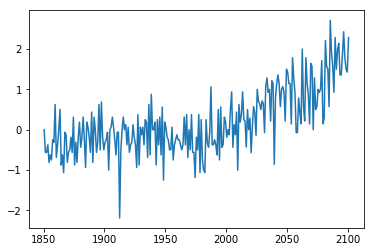

In [420]:
Panom=cmip5.cdms_clone(vec_day_of_peak(P)-np.repeat(vec_day_of_peak(Pclim)[:,np.newaxis],nyears,axis=1),P)

#[Plotting.time_plot(Panom[i],c="k",lw=.4,alpha=.4) for i in range(16)]
Plotting.time_plot(MV.average(Panom,axis=0))


([<matplotlib.axis.XTick at 0x12682f2b0>,
 <a list of 12 Text xticklabel objects>)

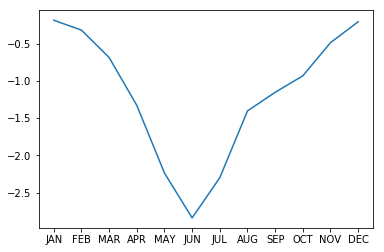

In [323]:
plt.plot(clim_old[7].asma())
months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
plt.xticks(np.arange(12),months)

In [264]:
print(stats.circmean([1.5*np.pi]))
print(1.5*np.pi)

4.71238898038469
4.71238898038469


In [223]:
np.cos(np.pi/2)

6.123233995736766e-17

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


86.0

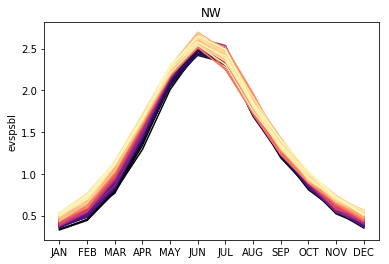

In [219]:
ssp=EV.ensemble_average("ssp585")
historical=EV.ensemble_average("historical")
test=ssp[7]
EV.plot_seasonal_trends()
test.shape[0]/12

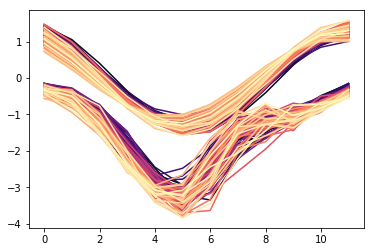

In [212]:
for i in range(86):
    plt.plot(phase_angle_form(test.asma()[12*i:12*(i+1)]),c=cm.magma(i/86.))
    plt.plot(test.asma()[12*i:12*(i+1)],c=cm.magma(i/86.))

In [215]:
def phase_to_day(phase):
    """Convert phase to day of the year """
    if phase < 0:
        phase += 2*np.pi
    return phase*(365./(2*np.pi))
def phase_anomaly(phase,reference):
    lead = phase_to_day(phase-reference)
    lag = -1*phase_to_day(reference - phase)
    LL = np.array([lead,lag])
    i = np.argmin(np.abs(LL))
    return LL[i]
pa=np.vectorize(phase_anomaly)
vf=np.vectorize(phase_to_day)

In [160]:
def phase_angle_form(obs,period=12):
    mag,phase = get_cycle(obs,period = period)
    ###TEST
    mag=2*mag
    return mag*np.cos(2*np.pi/period*np.arange(len(obs))+phase)

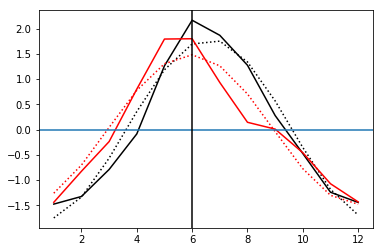

In [119]:
test=h85[0].asma()[:12]
X=np.arange(12)+1
plt.plot(X,test-np.average(test),c="k")
plt.plot(X,phase_angle_form(test),c="k",ls=":")

test2=h85[0].asma()[-12:]
plt.plot(X,test2-np.average(test2),c="r")
plt.plot(X,phase_angle_form(test2),c="r",ls=":")

plt.axhline(0)
plt.axvline(6,c="k")


In [128]:
print(get_cycle(test2)[-1])
print(get_cycle(test)[-1])
#print(phase_to_day(get_cycle(test)[-1])

-2.5897472190994555
-2.940845443273049


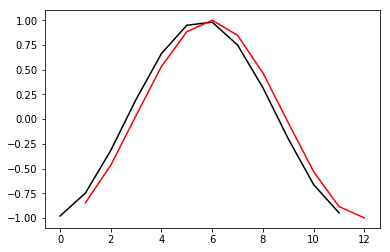

In [137]:
obs=np.arange(12)
phase=-2.94
period=12
plt.plot(np.cos(2*np.pi/period*np.arange(len(obs))+phase),c="k")

phase=-2.58
period=12
plt.plot(X,np.cos(2*np.pi/period*np.arange(len(obs))+phase),c="r")

phase=0

variable_82767
masked_array(
  data=[[-168.49803209982545, -164.03087683375824, -157.97368624061184,
         ..., -156.31746081922043, -157.49884477621697,
         -148.3815856601405],
        [-158.51865649055333, -160.6686358098262, -157.58127198918703,
         ..., -140.06605972157467, -145.5372811771249,
         -130.73416896148623],
        [-171.4248749703279, -168.523971244758, -169.43366254077802, ...,
         -158.80919389540682, -154.11382109504905, -147.9298668771211],
        ...,
        [-169.32348760388962, -169.3468288239387, -169.6732100272702,
         ..., -164.58033553697692, -165.74314396293403,
         -163.7314443591695],
        [-164.28093228607628, -165.44867267219956, -164.9220213513287,
         ..., -161.43526975318827, -162.81610209170162,
         -164.85776793543985],
        [-166.93824719345085, -166.49169629906316, -166.99658651938145,
         ..., -155.45267223420046, -160.15266974111609,
         -158.6334526602858]],
  mask=[[False, False, F

In [70]:
np.argmin(Pday[:,0])

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


8

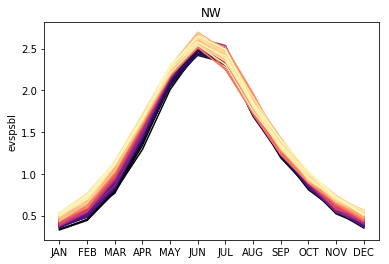

In [65]:
EV.plot_seasonal_trends()

In [67]:
import datetime
dt=datetime.datetime(1950,1,1)
dtdelta=datetime.timedelta(days=205)
dt+dtdelta

datetime.datetime(1950, 7, 25, 0, 0)

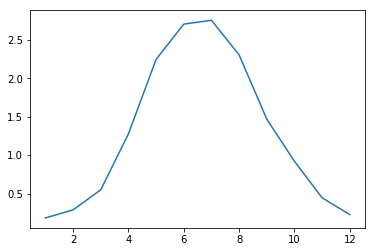

In [110]:
i=120
plt.plot(np.arange(12)+1,h85[0,12*i:12*(i+1)].asma())

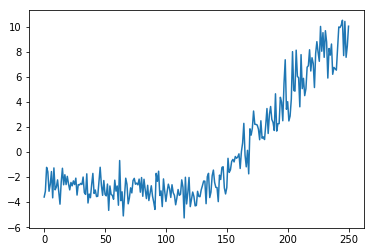

In [96]:
plt.plot(np.ma.average(Pday[:7]-np.repeat(np.average(Pday[:7].asma(),axis=1)[:,np.newaxis],nyears,axis=1),axis=0))

[[<matplotlib.lines.Line2D at 0x1286fac50>],

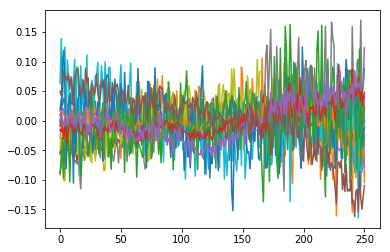

In [116]:
Aanom=A-np.repeat(np.ma.average(A,axis=1)[:,np.newaxis],nyears,axis=1)
[plt.plot(Aanom[i].asma()) for i in range(16)]

In [247]:
import datetime
def time_of_year(day):
    dt=datetime.datetime(1950,1,1)
    deltat=datetime.timedelta(days=day)
    test=dt+deltat
    return str(test.month)+"-"+str(test.day)